In [ ]:
#!python -m spacy download en_core_web_lg

In [1]:
import numpy as np
import pandas as pd
import selenium as se
import seaborn as sns
import spacy
import openpyxl
import nltk
import ssl
import re
import sklearn
import gensim
import en_core_web_lg

from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from nltk.corpus import words

# NLP stuff
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from spacy.pipeline import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [19]:
df_big_easy = pd.read_excel('Reviews_tripadvisor.xlsx')
df_big_easy.head(3)

,reviewId,author,authorUrl,reviewTitle,reviewBody,reviewRating,dateCreated,images,dateOfVisit,helpfulCount,reviewUrl,name,address,aggregateRating,ratingCount,input
0,732773307,Ingobells,https://www.tripadvisor.com/Profile/Ingobells,Fantastic Company Christmas Party,What a brilliant Christmas Party! Music playin...,5.0,2019-12-15,NaN,December 2019,0,https://www.tripadvisor.com/ShowUserReviews-g1...,Big Easy,"Crossrail Place Park Level, Canary Wharf, Lond...",3.5,2196,https://www.tripadvisor.com/Restaurant_Review-...
1,791713937,sarahbY7803SD,https://www.tripadvisor.com/Profile/sarahbY7803SD,Big Easy Brunch,Visited the Canary Wharf Big Easy on a Saturda...,2.0,2021-06-08,NaN,June 2021,0,https://www.tripadvisor.com/ShowUserReviews-g1...,Big Easy,"Crossrail Place Park Level, Canary Wharf, Lond...",3.5,2196,https://www.tripadvisor.com/Restaurant_Review-...
2,789136533,bajbaje,https://www.tripadvisor.com/Profile/bajbaje,Excellent Service! Good Food! Value for Money!,"Our waiter Marco was superb, attentive and mad...",5.0,2021-05-18,https://media-cdn.tripadvisor.com/media/photo-...,May 2021,1,https://www.tripadvisor.com/ShowUserReviews-g1...,Big Easy,"Crossrail Place Park Level, Canary Wharf, Lond...",3.5,2196,https://www.tripadvisor.com/Restaurant_Review-...


In [20]:
df_big_easy.shape

(170, 16)

### Remove duplicate reviews, keep interesting columns, remove rows with review missing

In [21]:
df_big_easy_reviewer_dedup = df_big_easy.drop_duplicates(subset='author')

df_big_easy_clean = df_big_easy_reviewer_dedup[['reviewTitle', 
                                                 'reviewBody', 
                                                 'reviewRating', 
                                                 'dateCreated', 
                                                 'helpfulCount']].copy(deep=True)
df_big_easy_clean = df_big_easy_clean.dropna(subset=['reviewBody'])
print(df_big_easy_clean.shape)

# Join review title into body of review
df_big_easy_clean['review_all'] = df_big_easy_clean.apply(lambda row: row['reviewTitle'] + '. ' + row['reviewBody'],
                                                          axis=1)

df_big_easy_clean = df_big_easy_clean.drop(['reviewTitle', 'reviewBody'], axis=1)

df_big_easy_clean.head()

(170, 5)


,reviewRating,dateCreated,helpfulCount,review_all
0,5.0,2019-12-15,0,Fantastic Company Christmas Party. What a bril...
1,2.0,2021-06-08,0,Big Easy Brunch. Visited the Canary Wharf Big ...
2,5.0,2021-05-18,1,Excellent Service! Good Food! Value for Money!...
3,5.0,2021-07-29,0,"Marco, a star from top to bottom!. We've known..."
4,1.0,2021-07-06,0,The worst experience ever. I booked two tables...


### Language cleaning

Start by cleaning text

In [22]:
def clean_text(text):
    
    tokens = text.split(' ')
    tokens_lower = [t.lower() for t in tokens]
    tokens_alpha = [re.sub('[^A-z]', '', t) for t in tokens_lower]
    text_clean = ' '.join(tokens_alpha)
    
    return text_clean
    

df_big_easy_clean['review_lower_alpha'] = df_big_easy_clean.apply(lambda row: clean_text(row['review_all']),
                                                                  axis=1)

df_big_easy_clean.head()

,reviewRating,dateCreated,helpfulCount,review_all,review_lower_alpha
0,5.0,2019-12-15,0,Fantastic Company Christmas Party. What a bril...,fantastic company christmas party what a brill...
1,2.0,2021-06-08,0,Big Easy Brunch. Visited the Canary Wharf Big ...,big easy brunch visited the canary wharf big e...
2,5.0,2021-05-18,1,Excellent Service! Good Food! Value for Money!...,excellent service good food value for money ou...
3,5.0,2021-07-29,0,"Marco, a star from top to bottom!. We've known...",marco a star from top to bottom weve known the...
4,1.0,2021-07-06,0,The worst experience ever. I booked two tables...,the worst experience ever i booked two tables ...


Then check how many words are in English corpus.

In [23]:
eng_words = words.words('en')
eng_words_lower = [w.lower() for w in eng_words]

In [24]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
sw = stopwords.words('english')

In [25]:
df_big_easy_eng = df_big_easy_clean.copy(deep=True)

# Assume any review where > 50% of first 10 words are in English corpus, is an English review
def pct_review_words_in_eng_corpus(text):
    
    tokens = text.split(' ')[:10]
    n_tokens = len(tokens)
    tokens_in_eng_corpus = np.sum([1 if t in eng_words_lower else 0 for t in tokens])
    
    return float(tokens_in_eng_corpus)/n_tokens


df_big_easy_eng['is_english'] = df_big_easy_eng.apply(lambda row: pct_review_words_in_eng_corpus(row['review_lower_alpha']) >= 0.5,
                                                      axis=1)

# Drop rows
df_big_easy_eng = df_big_easy_eng[df_big_easy_eng['is_english']==True].drop(['is_english'], axis=1)



from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()


# Then remove stopwords and take lemmas
def clean_text(text): 
    
    tokens = text.strip().split(' ')
    
    # Remove stopwords
    tokens_no_sw = [t for t in tokens if t not in sw]
    
    # Take lemmas
    lemmas = [wnl.lemmatize(t, pos='v') for t in tokens_no_sw]
    
    # Join back together as single string
    clean_text = ' '.join(lemmas)
    
    # Handle duplicate spaces
    return re.sub(r'(\s)+', ' ', clean_text)


df_big_easy_eng['review_clean'] = df_big_easy_eng['review_lower_alpha'].apply(lambda t: clean_text(t))
df_big_easy_eng = df_big_easy_eng.drop('review_lower_alpha', axis=1)

df_big_easy_eng.head()

,reviewRating,dateCreated,helpfulCount,review_all,review_clean
0,5.0,2019-12-15,0,Fantastic Company Christmas Party. What a bril...,fantastic company christmas party brilliant ch...
1,2.0,2021-06-08,0,Big Easy Brunch. Visited the Canary Wharf Big ...,big easy brunch visit canary wharf big easy sa...
2,5.0,2021-05-18,1,Excellent Service! Good Food! Value for Money!...,excellent service good food value money waiter...
3,5.0,2021-07-29,0,"Marco, a star from top to bottom!. We've known...",marco star top bottom weve know place already ...
4,1.0,2021-07-06,0,The worst experience ever. I booked two tables...,worst experience ever book two table six peopl...


# NLP stuff

### Basic analysis

<AxesSubplot:xlabel='reviewRating', ylabel='count'>

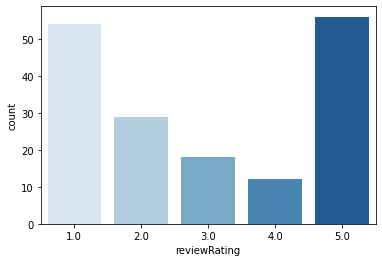

In [26]:
sns.countplot(data=df_big_easy_eng,
              x='reviewRating',
              palette='Blues')

Look over time

In [30]:
df_big_easy_eng['dateCreated'] = df_big_easy_eng['dateCreated'].astype('datetime64[D]')
df_monthly = df_big_easy_eng.set_index('dateCreated').resample('M')['reviewRating'].agg(('mean','count'))
df_monthly #= df_monthly.query('')

,mean,count
dateCreated,,
2019-12-31,3.142857,14
2020-01-31,2.933333,15
2020-02-29,3.000000,16
2020-03-31,2.285714,7
2020-04-30,4.000000,1
2020-05-31,NaN,0
2020-06-30,NaN,0
2020-07-31,4.000000,1
2020-08-31,NaN,0


(83, 5)
(30, 5)
(56, 5)


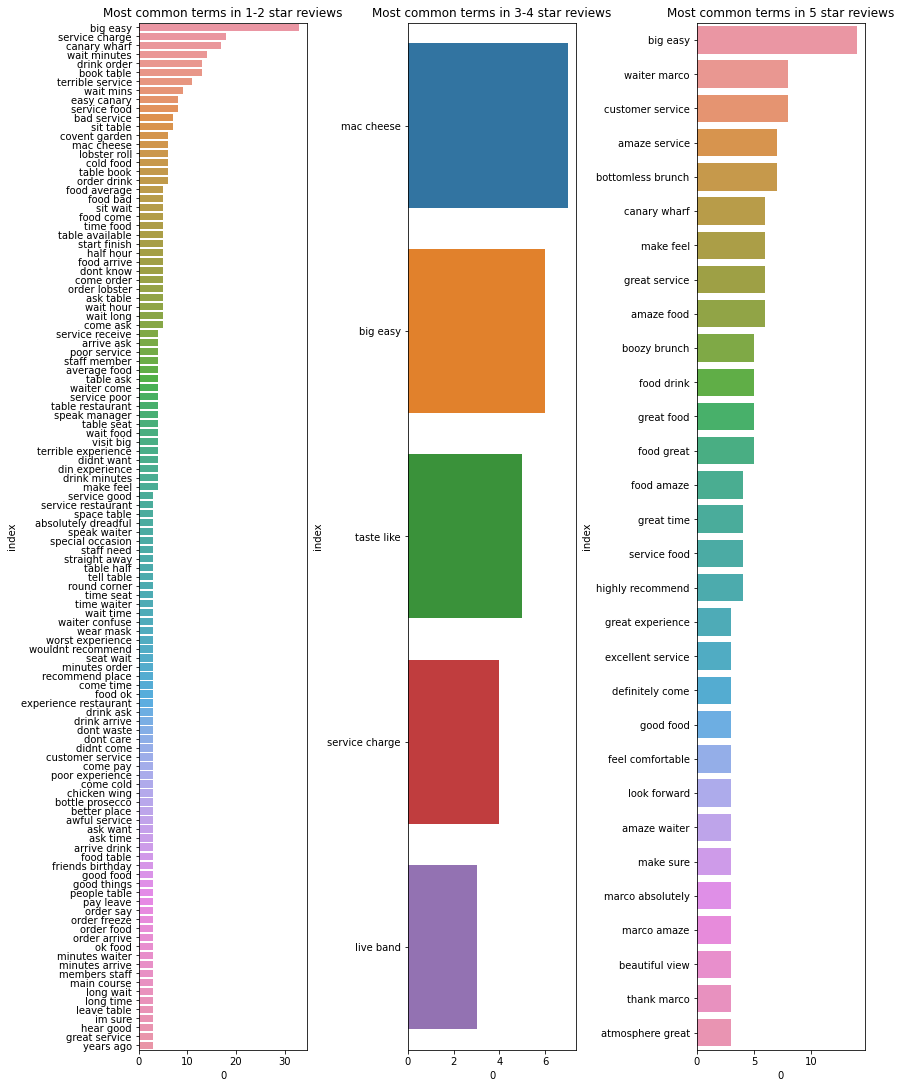

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,15),
                        constrained_layout=True)

# Bucket reviews into 1-2 stars, 3-4 stars, and 5 stars
review_buckets = {0: [1, 2], 
                  1: [3, 4], 
                  2: [5, 5]}

for i in range(3):
    
    # Get review bucket
    rev_min, rev_max = review_buckets[i]
    
    # Filter for certain reviews
    df_filt = df_big_easy_eng.query(f'reviewRating>={rev_min} and reviewRating<={rev_max}')
    print(df_filt.shape)
    
    # Set up vectorizer
    C = CountVectorizer(ngram_range=(2,2),
                        max_df=1.0,
                        min_df=3,
                        stop_words='english')
    
    # Get counts
    res = C.fit_transform(df_filt['review_clean'])
    
    # Set up dataframe
    df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())
    

    # Turn into plottable format
    df_plot = df_res.T.apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False).reset_index()
    
    # Plot
    sns.barplot(data=df_plot,
                # When you use reset_index() on a series, you end up with index and 0 as column names
                x=0,
                y='index',
                ax=axs[i])
    
    if rev_min == rev_max:
        title_stars = f'{rev_min} star'
    else:
        title_stars = f'{rev_min}-{rev_max} star'
    
    axs[i].set_title(f'Most common terms in {title_stars} reviews')

### Entity recognition

Get english language and test parsing on one example

In [32]:
nlp = spacy.load("en_core_web_lg")

In [54]:
row = 40
doc = nlp(df_big_easy_eng.reset_index()['review_all'][row])

print(doc[:20], df_big_easy_eng.reset_index()['reviewRating'][row], sep='\n')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, spacy.explain(token.dep_),
            token.shape_, token.is_alpha, token.is_stop, sep=', ')

Great experience. Really nice meal and also great service from our server Marco. Felt looked after the whole
5.0
Great, great, ADJ, JJ, amod, adjectival modifier, Xxxxx, True, False
experience, experience, NOUN, NN, ROOT, None, xxxx, True, False
., ., PUNCT, ., punct, punctuation, ., False, False
Really, really, ADV, RB, advmod, adverbial modifier, Xxxxx, True, True
nice, nice, ADJ, JJ, amod, adjectival modifier, xxxx, True, False
meal, meal, NOUN, NN, ROOT, None, xxxx, True, False
and, and, CCONJ, CC, cc, coordinating conjunction, xxx, True, True
also, also, ADV, RB, advmod, adverbial modifier, xxxx, True, True
great, great, ADJ, JJ, amod, adjectival modifier, xxxx, True, False
service, service, NOUN, NN, conj, conjunct, xxxx, True, False
from, from, ADP, IN, prep, prepositional modifier, xxxx, True, True
our, our, PRON, PRP$, poss, possession modifier, xxx, True, True
server, server, NOUN, NN, pobj, object of preposition, xxxx, True, False
Marco, Marco, PROPN, NNP, appos, appositiona

Visualise dependencies

In [55]:
spacy.displacy.render(doc,
                      options={'compact':True})

In [56]:
spacy.displacy.render(doc, style='ent')

/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

Go one step further, and label data with dependencies

In [38]:
# Document is list of sentences, .sents is a generator object that allows us to grab these
sentences = list(doc.sents)

# Get function to extract information from sentences
def get_dependency_data(sentence):
    for word in sentence:
        output_prelim = f'{word} has '
        dep = word.dep_
        dep_first_letter = dep[0] if dep is not None else None

        if spacy.explain(dep) is not None:
            suffix = f'label {dep} ({spacy.explain(dep)})'
        else:
            suffix = f'label {dep}'
        
        print(output_prelim + suffix)
        

for s in sentences:
    get_dependency_data(s)
    print('---------------\n')
        
        

Terrible has label ROOT
. has label punct (punctuation)
---------------

Been has label ROOT
to has label prep (prepositional modifier)
big has label pobj (object of preposition)
easy has label advmod (adverbial modifier)
a has label quantmod (modifier of quantifier)
few has label amod (adjectival modifier)
times has label npadvmod (noun phrase as adverbial modifier)
, has label punct (punctuation)
gone has label dep (unclassified dependent)
so has label advmod (adverbial modifier)
down has label prep (prepositional modifier)
hill has label pobj (object of preposition)
! has label punct (punctuation)
---------------

Food has label nsubj (nominal subject)
was has label ccomp (clausal complement)
cold has label acomp (adjectival complement)
, has label punct (punctuation)
waiters has label nsubj (nominal subject)
were has label ROOT
incompetent has label acomp (adjectival complement)
. has label punct (punctuation)
---------------

No has label det (determiner)
one has label nsubj (nomi

### LDA

Get counts for all 1-2 grams in reviews

In [39]:
C = CountVectorizer(ngram_range=(1,2),
                    max_df=1.0,
                    min_df=3,
                    stop_words='english')
    
# Get counts
res = C.fit_transform(df_big_easy_eng['review_clean'])

# To dataframe
df_res = pd.DataFrame(data=res.todense(),
                          columns=C.get_feature_names())

In [40]:
df_res.head()

,able,abrupt,absolute,absolutely,absolutely dreadful,accommodate,acknowledge,actually,add,advance,...,wouldnt,wouldnt recommend,write,wrong,year,years,years ago,young,youre,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [41]:
list_of_list_of_tokens = [rev.split() for rev in df_big_easy_eng['review_clean']]
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

In [42]:
num_topics = 15
lda_model = LdaModel(corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary_LDA, 
                     passes=4)#,
                     #alpha=[0.01]*num_topics,
                     #eta=[0.01]*len(dictionary_LDA.keys()))

In [43]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.020*"food" + 0.018*"service" + 0.013*"best" + 0.011*"say" + 0.009*"waiter" + 0.009*"really" + 0.009*"come" + 0.009*"didnt" + 0.008*"one" + 0.008*"place"

1: 0.021*"service" + 0.020*"food" + 0.015*"good" + 0.014*"lobster" + 0.012*"experience" + 0.011*"order" + 0.011*"arrive" + 0.010*"great" + 0.009*"roll" + 0.009*"take"

2: 0.015*"go" + 0.015*"food" + 0.014*"amaze" + 0.014*"great" + 0.014*"time" + 0.014*"order" + 0.012*"drink" + 0.011*"staff" + 0.011*"service" + 0.010*"ask"

3: 0.025*"food" + 0.016*"great" + 0.013*"service" + 0.013*"order" + 0.013*"lobster" + 0.012*"bbq" + 0.011*"go" + 0.011*"time" + 0.010*"come" + 0.008*"easy"

4: 0.022*"us" + 0.021*"come" + 0.016*"order" + 0.015*"table" + 0.015*"ask" + 0.013*"get" + 0.013*"wait" + 0.012*"time" + 0.012*"food" + 0.012*"go"

5: 0.017*"go" + 0.013*"tip" + 0.013*"food" + 0.013*"service" + 0.011*"staff" + 0.010*"ask" + 0.010*"even" + 0.009*"say" + 0.008*"thank" + 0.008*"back"

6: 0.022*"table" + 0.013*"food" + 0.011*"book" + 0.011*"ask

Get sentiment against each topic

In [49]:
df_big_easy_eng_r = df_big_easy_eng.reset_index(drop=True)

sentiment_by_topic = []

# For each corpus, get rating
for idx, row in df_big_easy_eng_r.iterrows():
    
    # Get topics relevant to that row. This returns list of tuples, where first tuple is first topic, and first item in tuple is the topic id
    topic = lda_model[corpus[idx]][0][0]
    
    # Get sentiment
    sentiment = row['reviewRating']
    
    if topic == 6:
        print(sentiment, row['review_all'][:100], sep=' ** ')
    
    # Append for first topic tagged
    sentiment_by_topic.append([sentiment, topic])

1.0 ** The worst experience ever. I booked two tables of six for a 12 people birthday celebration. I accept
1.0 ** Terrible avoid. Went here with a friend, they don’t have outdoor heating. Also, we were treated diff
2.0 ** Poor. Visited with my girlfriend for our anniversary dinner. Queue was ridiculous even though everyo
1.0 ** Bad experience. We visited the big easy this afternoon for a friends birthday, we booked on line two
1.0 ** Big easy canary wharf is a COVID Timebomb. Avoid at all costs if you want to stay healthy. The queue
1.0 ** The worst experience I ever had in restaurant!. My partner took me to Big Easy Canary Wharf to celeb
1.0 ** Unmitigated Shambles. the lockdown has not been kind to these lot. The whole visit was a hot mess. I
5.0 ** Anniversary treat!. Booked on a whim on the final day of our anniversary trip. We booked for 11.45 b
2.0 ** Poor Service, Mediocre Food, Not Covid Safe. We did book in advance however were met with a large qu
2.0 ** Won’t be rushing back

<AxesSubplot:xlabel='rating', ylabel='topic'>

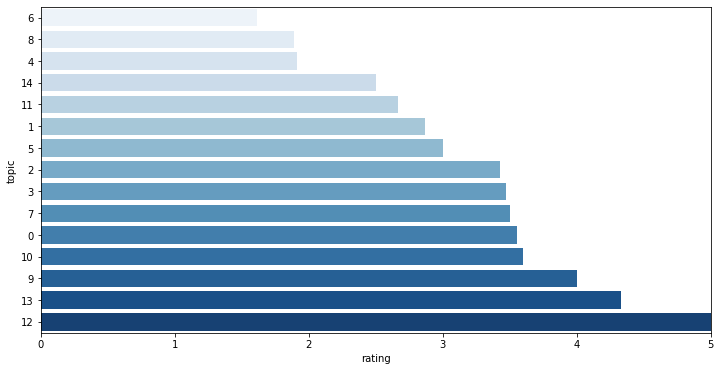

In [46]:
df_sentiment_by_topic = pd.DataFrame(data=sentiment_by_topic,
                                     columns=['rating', 'topic'])

df_sentiment_by_topic['topic'] = df_sentiment_by_topic['topic'].astype(str)

#print(df_sentiment_by_topic['topic'].value_counts())


plt.figure(figsize=(12,6))
plt.xlim((0,5))

# Collapse
sns.barplot(data=df_sentiment_by_topic.groupby('topic')['rating'].mean().reset_index().sort_values(by='rating'),
              y='topic',
              x='rating',
            palette='Blues')

In [47]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Users/jackcook/PycharmProjects/reviews-tool/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Outputs

**Q: How do my reviews look over time - are they getting worse or better?**

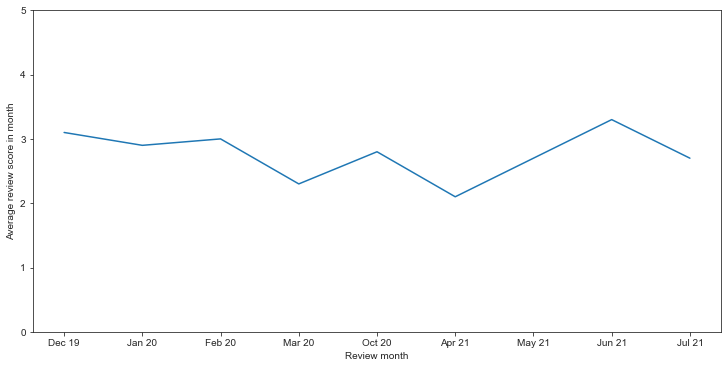

In [48]:
from datetime import datetime
sns.set_style('ticks')

# Group reviews by month
df_monthly_output = df_big_easy_eng.set_index('dateCreated').resample('M')['reviewRating'].agg(('mean','count')).reset_index()

# Due to lockdown, some months have next to no reviews - set months with 5 or less reviews to score of 0
#df_monthly_output.loc[df_monthly_output['count'] < 5, 'mean'] = 0
df_monthly_output = df_monthly_output.query('count > 5')

# Convert datetime into date, and round 'mean' to 1 decimal place
df_monthly_output['dateCreated'] = [d.strftime("%b %y") for d in df_monthly_output['dateCreated']]
df_monthly_output['mean'] = df_monthly_output['mean'].map(lambda n: np.around(n, 1))

# Plot
plt.figure(figsize=(10,5), constrained_layout=True)
chart = sns.lineplot(data=df_monthly_output,
                     x='dateCreated',
                     y='mean',
                     palette='Blues')
#chart.bar_label(chart.containers[0])
plt.xlabel('Review month')
plt.ylabel('Average review score in month')
plt.ylim(0,5)
plt.show()

In [67]:
df_weekday_output = df_big_easy_eng.copy(deep=True)
df_weekday_output['day_of_week'] = df_weekday_output['dateCreated'].dt.weekday
df_weekday_output['day_of_week'] = [7 if d==0 else d for d in df_weekday_output['day_of_week']]
df_weekday_output = df_weekday_output.groupby('day_of_week')['reviewRating'].agg(('mean','count')).reset_index()
df_weekday_output

,day_of_week,mean,count
0,1,2.818182,33
1,2,2.312500,16
2,3,2.947368,19
3,4,2.944444,18
4,5,3.366667,30
5,6,2.692308,26
6,7,3.111111,27


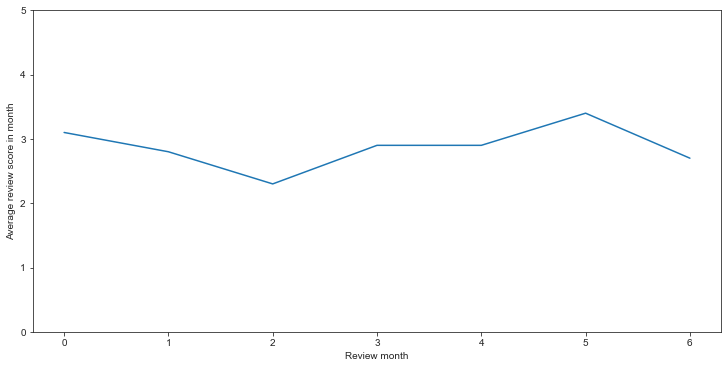

In [58]:
# Group reviews by weekday
df_weekday_output = df_big_easy_eng.copy(deep=True)
df_weekday_output['day_of_week'] = df_weekday_output['dateCreated'].dt.weekday
df_weekday_output = df_weekday_output.groupby('day_of_week')['reviewRating'].agg(('mean','count')).reset_index()

# Due to lockdown, some months have next to no reviews - set months with 5 or less reviews to score of 0
#df_monthly_output.loc[df_monthly_output['count'] < 5, 'mean'] = 0
df_weekday_output = df_weekday_output.query('count > 5')

# Round 'mean' to 1 decimal place
df_weekday_output['mean'] = df_weekday_output['mean'].map(lambda n: np.around(n, 1))

# Plot
plt.figure(figsize=(10,5), constrained_layout=True)
chart = sns.lineplot(data=df_weekday_output,
                     x='day_of_week',
                     y='mean',
                     palette='Blues')
#chart.bar_label(chart.containers[0])
plt.xlabel('Review month')
plt.ylabel('Average review score in month')
plt.ylim(0,5)
plt.show()